### Import modules

In [190]:
import pandas as pd
import json
import seaborn as sns
import datetime
import time
import numpy as np
from matplotlib import pyplot as plt

### Loading dataset into dataframe

In [191]:
list_transactions = []
with open('transactions.txt') as fp:
    for line in fp:
        list_transactions.append(json.loads(line))

df = pd.DataFrame(list_transactions)

### Structure of the data

There are **786,363** records and **29** fields in the dataset.

In [192]:
#number of records and fields in the dataframe
print(df.shape)
print(df.columns)

(786363, 29)
Index(['accountNumber', 'accountOpenDate', 'acqCountry', 'availableMoney',
       'cardCVV', 'cardLast4Digits', 'cardPresent', 'creditLimit',
       'currentBalance', 'currentExpDate', 'customerId',
       'dateOfLastAddressChange', 'echoBuffer', 'enteredCVV',
       'expirationDateKeyInMatch', 'isFraud', 'merchantCategoryCode',
       'merchantCity', 'merchantCountryCode', 'merchantName', 'merchantState',
       'merchantZip', 'posConditionCode', 'posEntryMode', 'posOnPremises',
       'recurringAuthInd', 'transactionAmount', 'transactionDateTime',
       'transactionType'],
      dtype='object')


### Summary statistics
Lets see a quick statistic summary of the data

In [193]:
df.describe()

,availableMoney,creditLimit,currentBalance,transactionAmount
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,6250.725369,10759.464459,4508.739089,136.985791
std,8880.783989,11636.174890,6457.442068,147.725569
min,-1005.630000,250.000000,0.000000,0.000000
25%,1077.420000,5000.000000,689.910000,33.650000
50%,3184.860000,7500.000000,2451.760000,87.900000
75%,7500.000000,15000.000000,5291.095000,191.480000
max,50000.000000,50000.000000,47498.810000,2011.540000


Now list the unique values for each field in the dataframe as **(fieldname, number of unique values, unique values)**

In [194]:
for col in df:
    if col not in ['cardCVV', 'currentExpDate', 'enteredCVV']:
        print((col, df[col].nunique(), df[col].unique()))
        print()

('accountNumber', 5000, array(['737265056', '830329091', '574788567', ..., '899818521',
       '638498773', '732852505'], dtype=object))

('accountOpenDate', 1820, array(['2015-03-14', '2015-08-06', '2015-10-13', ..., '2009-08-17',
       '2008-04-15', '2012-08-23'], dtype=object))

('acqCountry', 5, array(['US', '', 'CAN', 'MEX', 'PR'], dtype=object))

('availableMoney', 521916, array([ 5000.  ,  4990.63,  4959.25, ..., 48766.15, 48716.72, 48666.83]))

('cardLast4Digits', 5246, array(['1803', '767', '3143', ..., '4635', '3783', '3388'], dtype=object))

('cardPresent', 2, array([False,  True]))

('creditLimit', 10, array([ 5000.,  2500., 50000., 15000., 10000.,   250.,   500.,  1000.,
        7500., 20000.]))

('currentBalance', 487318, array([   0.  ,    9.37,   40.75, ..., 1095.04, 1214.96, 1233.85]))

('customerId', 5000, array(['737265056', '830329091', '574788567', ..., '899818521',
       '638498773', '732852505'], dtype=object))

('dateOfLastAddressChange', 2184, array(['2015-03

Lets now count **null values** for each of remaining fields.

In [195]:
for col in df:
    if df[col].dtype == 'object' and df[df[col] == ''].shape[0] > 0: #fields where data type is string
        print(col, df[df[col] == ''].shape[0])
    elif df[col].isna().sum() > 0:
        print(col, df[col].isna().sum())

acqCountry 4562
echoBuffer 786363
merchantCity 786363
merchantCountryCode 724
merchantState 786363
merchantZip 786363
posConditionCode 409
posEntryMode 4054
posOnPremises 786363
recurringAuthInd 786363
transactionType 698


### Histogram of the Processed Amounts of Each Transaction

The distribution of processed amounts of transactions is **right skewed**, that means it is not symmetric around the mean. The mean is greater than the median. Also notice that the tail of the distribution on the right hand (positive) side is longer than on the left hand side.

My hypothesis is customers use credit card mostly for small transactions.

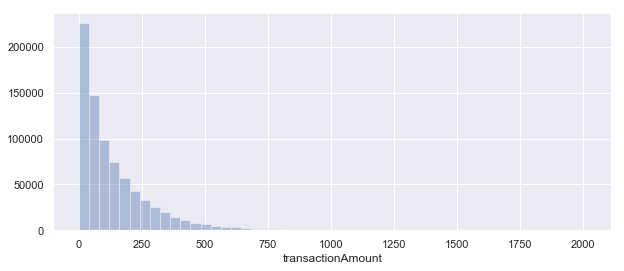

In [196]:
sns.distplot(df['transactionAmount'], hist = True, kde = False)
plt.show()

### Duplicate Transactions

First find the total count of duplicates that resulted from **reversed transactions**.

In [30]:
dfUniqueTransaction = df[['accountNumber', 'merchantName', 'transactionType', 'transactionAmount', 'transactionDateTime']]
dfPurchase = dfUniqueTransaction[df['transactionType'] == 'PURCHASE']
dfReversal = dfUniqueTransaction[df['transactionType'] == 'REVERSAL']

totalReversedDuplicates = 0
totalReversedDuplicatesAmount = 0

dfPurchaseSameAccount = None
prevAccountNumber = None

for _, row in dfReversal.iterrows():
    if row['accountNumber'] != prevAccountNumber:
        dfPurchaseSameAccount = dfPurchase[dfPurchase['accountNumber'] == row['accountNumber']]
        prevAccountNumber = row['accountNumber']
    if ((dfPurchaseSameAccount['transactionAmount'] == row['transactionAmount']) & (dfPurchaseSameAccount['merchantName'] == row['merchantName']) & (row['transactionDateTime'] > dfPurchaseSameAccount['transactionDateTime'])).any():
        totalReversedDuplicates += 1
        totalReversedDuplicatesAmount += row['transactionAmount']

print('Total number of reversal duplicates: ', totalReversedDuplicates)
print('Total dollar amount of reversal duplicates: $', totalReversedDuplicatesAmount)

Total number of reversal duplicates:  17759
Total dollar amount of reversal duplicates: $ 2666519.26999999


Now we will find total count of duplicates that resulted from **multiple swipes**.

In [31]:
dfUniqueTransaction = df[['accountNumber', 'merchantName', 'transactionType', 'transactionAmount', 'transactionDateTime']]
dfPurchase = dfUniqueTransaction[dfUniqueTransaction['transactionType'] == 'PURCHASE']
dfPurchase =dfPurchase.reset_index(drop=True)

totalMultiSwipeDuplicates = 0
totalMultiSwipeDuplicatesAmount = 0

lastSeenDuplicateTransaction = -1

for index1, row in dfPurchase.iterrows():
        
    if index1 < lastSeenDuplicateTransaction:
        continue
        
    for index2 in range(index1+1, dfPurchase.shape[0]):
        if row['accountNumber'] != dfPurchase.iloc[index2]['accountNumber']:
            break
        t1 = pd.to_datetime(row['transactionDateTime'])
        t2 = pd.to_datetime(dfPurchase.iloc[index2]['transactionDateTime'])
        
        
        if pd.Timedelta(t2 - t1).seconds > 300:
            break
                       
        if (row['merchantName'] == dfPurchase.iloc[index2]['merchantName']) and (row['transactionAmount'] == dfPurchase.iloc[index2]['transactionAmount']):
            totalMultiSwipeDuplicates += 1
            totalMultiSwipeDuplicatesAmount += row['transactionAmount']
            lastSeenDuplicateTransaction = index2    

print('Total number of multiple swipes duplicates: ', totalMultiSwipeDuplicates)
print('Total dollar amount of multiple swipes duplicates: $', totalMultiSwipeDuplicatesAmount)

Total number of multiple swipes duplicates:  7463
Total dollar amount of multiple swipes duplicates: $ 1103262.1899999934


Some interesting observation about the duplicate transactions:

* Five fields in the dataset were particularly important to identify both types of duplicate transactions
    * accountNumber
    * merchantName
    * transactionType
    * transactionAmount
    * transactionDateTime
    
    
* Mean value of the amount of both types of duplicate is nearly the same as mean value of total transaction amount. I can intuitively say that the duplicates do not form a distribution that is significantly different from the overall distribution of  transactions.

## Predictive Model

### Data preprocessing

We saw that **echoBuffer, merchantCity, merchantState, merchantZip, posOnPremises, recurringAuthInd** contain **null value** only. We will drop these fields from the dataframe.

In [197]:
df.drop(columns=['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd' ], axis=1, inplace=True)

Adding a new field **CVVmatched** that shows if entered CVV matched with original CVV

In [198]:
df['CVVmatched'] = df['enteredCVV'] == df['cardCVV']

Adding a new field **accountAge** that shows how long ago (in seconds) the account was opened until the transaction

In [199]:
df['accountAge'] = pd.to_datetime(df['transactionDateTime']) - pd.to_datetime(df['accountOpenDate'])
df['accountAge'] = df['accountAge'].dt.total_seconds()

Adding a new field **addressAge** that shows what how long (in seconds) the cardholder has been living in his last address until the transaction 

In [200]:
df['addressAge'] = pd.to_datetime(df['transactionDateTime']) - pd.to_datetime(df['dateOfLastAddressChange'])
df['addressAge'] = df['addressAge'].dt.total_seconds()

In [202]:
rs = np.random.RandomState(0)
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,availableMoney,cardPresent,creditLimit,currentBalance,expirationDateKeyInMatch,isFraud,transactionAmount,CVVmatched,accountAge,addressAge
availableMoney,1,0.00250818,0.834977,0.129332,0.0040673,-0.00153796,-0.0100699,-0.000582796,-0.0210275,0.0415915
cardPresent,0.00250818,1,-0.00392873,-0.0105289,0.0403929,-0.0434179,0.0373605,0.00298763,0.0205363,0.0137109
creditLimit,0.834977,-0.00392873,1,0.653652,0.00239136,0.00310771,0.00558069,0.0013426,-0.0615497,-0.0624685
currentBalance,0.129332,-0.0105289,0.653652,1,-0.00128451,0.00771515,0.0239052,0.00322084,-0.0819927,-0.169767
expirationDateKeyInMatch,0.0040673,0.0403929,0.00239136,-0.00128451,1,-0.000972409,0.00175128,0.00011312,0.00121994,0.00101405
isFraud,-0.00153796,-0.0434179,0.00310771,0.00771515,-0.000972409,1,0.075651,-0.0100058,-0.0058991,-0.00593282
transactionAmount,-0.0100699,0.0373605,0.00558069,0.0239052,0.00175128,0.075651,1,0.000700685,-0.00787902,-0.0284304
CVVmatched,-0.000582796,0.00298763,0.0013426,0.00322084,0.00011312,-0.0100058,0.000700685,1,4.69003e-05,-0.00124608
accountAge,-0.0210275,0.0205363,-0.0615497,-0.0819927,0.00121994,-0.0058991,-0.00787902,4.69003e-05,1,0.585585
addressAge,0.0415915,0.0137109,-0.0624685,-0.169767,0.00101405,-0.00593282,-0.0284304,-0.00124608,0.585585,1


For transactions with empty ('') **merchantCountryCode** value , below we see there is a higher ratio for a them being fraud.

KeyError: 'merchantCountryCode'

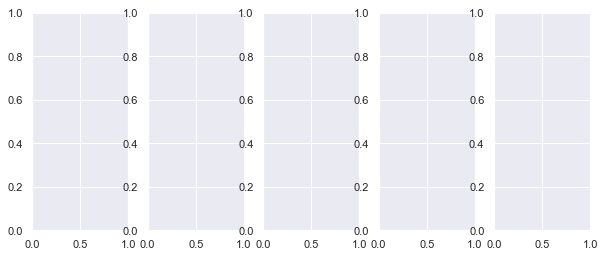

In [187]:
fig, ax = plt.subplots(1, 5)

for index, value in enumerate(df['merchantCountryCode'].unique()):
    sns.set(rc={'figure.figsize':(10, 4)})
    sns.countplot(x='merchantCountryCode', hue='isFraud', data=df[df['merchantCountryCode']== value], ax=ax[index])

fig.show()

In [93]:
# sns.set(rc={'figure.figsize':(20,5.27)})
# sns.countplot(x='merchantCategoryCode', hue = 'merchantCategoryCode', data=df)
# plt.show()

df[df['expirationDateKeyInMatch']==True]

,accountNumber,accountOpenDate,acqCountry,availableMoney,cardCVV,cardLast4Digits,cardPresent,creditLimit,currentBalance,currentExpDate,...,isFraud,merchantCategoryCode,merchantCountryCode,merchantName,posConditionCode,posEntryMode,transactionAmount,transactionDateTime,transactionType,CVVmatched
203,984504651,2015-07-27,US,36166.85,640,8332,True,50000.0,13833.15,10/2022,...,False,health,US,Walgreens #07609,01,05,130.75,2016-02-14T02:08:59,PURCHASE,True
1983,863358589,2014-02-15,US,1601.97,779,787,True,2500.0,898.03,08/2031,...,False,fastfood,US,Popeyes #996859,01,05,104.13,2016-08-20T07:04:17,PURCHASE,True
2045,863358589,2014-02-15,US,1481.36,779,787,True,2500.0,1018.64,09/2022,...,False,fastfood,US,Krispy Kreme #51392,01,02,127.12,2016-10-08T03:48:49,PURCHASE,True
2649,571750534,2015-06-29,US,2061.97,737,8292,True,2500.0,438.03,04/2023,...,False,entertainment,US,EZ Putt Putt #551896,01,02,75.91,2016-01-30T22:56:55,PURCHASE,True
5747,187912273,2013-05-20,US,1237.40,619,6863,True,2500.0,1262.60,11/2022,...,False,hotels,US,Hyatt House #161001,01,02,328.42,2016-01-28T06:31:55,PURCHASE,True
8964,934061435,2014-12-31,US,763.26,897,8157,True,5000.0,4236.74,07/2030,...,False,fastfood,US,Subway #611240,01,09,198.23,2016-07-26T01:11:51,PURCHASE,True
10477,745217385,2013-11-19,US,40.96,486,6091,True,250.0,209.04,07/2032,...,False,fastfood,US,Subway #410395,01,09,186.66,2016-12-20T14:04:57,PURCHASE,True
11583,869838014,2015-11-19,US,5192.04,129,5090,True,15000.0,9807.96,12/2021,...,False,food,US,Dinosaur Fries,01,09,382.74,2016-06-21T10:25:49,PURCHASE,True
12404,346419123,2015-04-14,,4924.44,149,9685,True,7500.0,2575.56,03/2030,...,False,fastfood,US,Hardee's #728387,01,09,9.05,2016-08-20T16:05:11,PURCHASE,True
12642,593440936,2012-12-08,US,371.08,407,9842,True,500.0,128.92,05/2029,...,False,entertainment,US,AMC #79863,01,05,90.38,2016-12-02T08:28:32,PURCHASE,True
